# 04b - Vertex AI - AutoML for Global Forecasting with Deep Learning - In GCP Console (no code)


### Prerequisites:
- 04 - Time Series Forecasting - Data Review in BigQuery

### Overview:
- Create Dataset
- Train Forecasting Model with AutoML
    - Training Method
    - Model Details
    - Training Options
    - Compute and Pricing
    - Review Training
- Forecasting Model
- Test Data in BigQuery
- Setup
- Results
    - Retrieve Test Data
    - Review Custom Metrics with SQL
    - Retrieve the Forecasting Data (raw series)
    - Visualize the Time Series with Forecast

### Resources:
- [Train an AutoML model (Cloud Console)](https://cloud.google.com/vertex-ai/docs/training/automl-console#forecasting)
- [Vertex AI Forecast: An Overview](https://cloud.google.com/blog/topics/developers-practitioners/vertex-forecast-overview)
- [Optimization objectives for tabular AutoML models](https://cloud.google.com/vertex-ai/docs/training/tabular-opt-obj#forecasting)
- [Evaluation metrics returned by Vertex AI](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models#evaluation_metrics_returned_by)

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04b_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04b_console.png">

---
## Create Dataset (Link to BigQuery Table)

From the Console:
- Go to Vertex AI
- Select `Datasets`
- Select `+ CREATE`

<img src="architectures/notebooks/04b_screenshots/ds_1.png">

- Name the Dataset `04b`
- Select `Tabular`
    - Select `Forecasting`
- Select `us-central (Iowa)`
- Select `CREATE`

<img src="architectures/notebooks/04b_screenshots/ds_2.png">

- Select `Select a table or view from BigQuery`
- Enter the BigQuery path (or browse) to the table created in notebook `04`
- Select `CONTINUE`

<img src="architectures/notebooks/04b_screenshots/ds_3.png">

- The `ANALYZE` tab will be displayed for review
- Select the `Series identifier column` as `start_station_name`
- Select the `Timestamp column` as `date`
- Select `TRAIN NEW MODEL`

<img src="architectures/notebooks/04b_screenshots/ds_4.png">

---
## Train Forecasting Model with AutoML

After creating the `Dataset` above, we selected `TRAIN NEW MODEL` which presents the first screen of the process

### Training Method

- Select `AutoML`
- Select `CONTINUE`

<img src="architectures/notebooks/04b_screenshots/train_1.png">

### Model Details

- For `Target column` select `num_trips`
- For `Series identifier column` select `start_station_name`
- For Timestamp column` select `date`
- For `Data granularity` select `Daily`
- For `Forecast horizon` enter `16`
- For `Context window` enter `16`
- Select `Export test dataset to BigQuery`
- For `BigQuery path` enter a new table for the same dataset
- Select `Cancel training` under `Data validation options
- Select `Manual` for `Data split`
    - Enter `splits` for `Data split column`
- Select `CONTINUE`

<img src="architectures/notebooks/04b_screenshots/train_2.png">

### Training Options

- Review the `Training options` overview of column names and assignments
- Under `ADVANCED OPTIONS` you can select the `Optimization objective`
    - The default is RMSE and used for this notebook
    - See more about [optimization objectives for forecasting models](https://cloud.google.com/vertex-ai/docs/training/tabular-opt-obj#forecasting)

<img src="architectures/notebooks/04b_screenshots/train_3.png">

### Compute and pricing

- For budget enter `1 hour`
- Select `START TRAINING`

<img src="architectures/notebooks/04b_screenshots/train_4.png">

### Review Training

- Under the Vertex AI section for `Training`, on the `TRAINING PIPELINES` tab you will see the job in progress with a `Status` of `Training`

<img src="architectures/notebooks/04b_screenshots/train_5.png">


---
## Forecasting Model

- When the Training is complete, `Status` of `Finished`, you can select the name of the `TRAINING PIPELINES` task to go to the model

<img src="architectures/notebooks/04b_screenshots/train_6.png">

- The first tab presented for the model is `EVALUATE` where you can see overall model metrics
    - Review the [metrics definitions here](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models#forecasting)
- Select the `MODEL PROPOERTIES` tab

<img src="architectures/notebooks/04b_screenshots/model_1.png">

- Review the model proprties
- Select `VIEW DETAILS` under `Column metadata`

<img src="architectures/notebooks/04b_screenshots/model_2.png">

- Select `DONE`
- Select the `BATCH PREDICTIONS` tab

<img src="architectures/notebooks/04b_screenshots/model_3.png">

- Review the options to create a batch predictions job
- Click `CANCEL` as we output the test predictions to BigQuery as part of the AutoML Training

<img src="architectures/notebooks/04b_screenshots/model_4.png">

---
## Test Data in BigQuery

- In the console go to `BigQuery` and expand the project, dataset, and select the table for the test data, select the `PREVIEW` tab:

<img src="architectures/notebooks/04b_screenshots/bq_1.png">


---
## Setup

inputs:

In [2]:
PROJECT_ID='statmike-demo3'
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04b'

packages:

In [3]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [4]:
bigquery = bigquery.Client()

---
## Results

### Retrieve Test Data

In [16]:
query = f"""
WITH
    RAW AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM RAW
    ),
    LEFTSIDE AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD
        GROUP BY start_station_name, date
    )
SELECT *
FROM LEFTSIDE
LEFT OUTER JOIN LEAD
USING (start_station_name, date, prediction_lead_days)
"""
autoML = bigquery.query(query = query).to_dataframe()
autoML

,start_station_name,date,prediction_lead_days,predicted_on_date,num_trips,splits,predicted_num_trips
0,Central Park S & 6 Ave,2016-09-15,0,2016-09-15,392,TEST,267.691803
1,Central Park W & W 96 St,2016-09-15,0,2016-09-15,75,TEST,103.424004
2,Central Park West & W 68 St,2016-09-15,0,2016-09-15,170,TEST,152.590286
3,Central Park West & W 72 St,2016-09-15,0,2016-09-15,180,TEST,192.884842
4,Central Park West & W 76 St,2016-09-15,0,2016-09-15,101,TEST,105.151428
...,...,...,...,...,...,...,...
178,Central Park West & W 100 St,2016-09-30,0,2016-09-30,13,TEST,45.748840
179,Central Park West & W 102 St,2016-09-30,0,2016-09-30,10,TEST,55.616005
180,W 106 St & Central Park West,2016-09-30,0,2016-09-30,32,TEST,70.004799
181,Grand Army Plaza & Central Park S,2016-09-30,0,2016-09-30,43,TEST,239.784668


### Review Custom Metrics with SQL

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divide by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$


It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [17]:
query = f"""
WITH
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT start_station_name, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE
FROM DIFFS
GROUP BY start_station_name, time_series_type
ORDER BY start_station_name, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

,start_station_name,time_series_type,MAPE,MAE,pMAE
0,Central Park North & Adam Clayton Powell Blvd,forecast,0.654675,48.432258,0.312466
1,Central Park S & 6 Ave,forecast,0.514239,82.766867,0.249674
2,Central Park W & W 96 St,forecast,0.527306,20.625376,0.208997
3,Central Park West & W 100 St,forecast,0.914481,16.458715,0.399605
4,Central Park West & W 102 St,forecast,0.493344,11.427508,0.220555
5,Central Park West & W 68 St,forecast,0.452185,42.465256,0.277891
6,Central Park West & W 72 St,forecast,0.573328,46.820275,0.257254
7,Central Park West & W 76 St,forecast,0.345610,25.237239,0.226216
8,Central Park West & W 85 St,forecast,1.032151,51.497179,0.419814
9,Grand Army Plaza & Central Park S,forecast,0.484295,48.235071,0.215399


Overall Metrics:

In [18]:
query = f"""
WITH
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE
FROM DIFFS
GROUP BY time_series_type
ORDER BY time_series_type    
"""
customMetricsOverall = bigquery.query(query = query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE
0,forecast,0.535616,35.661484,0.263732


### Retrieve the Forecasting Data (raw series)

In [8]:
query = f"""
SELECT start_station_name, date, splits, num_trips
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
ORDER by start_station_name, date
"""
rawSeries = bigquery.query(query = query).to_dataframe()

Retrieve key dates for visualization:

In [10]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-08-31,2016-09-15,2016-09-30,16


### Visualize The Time Series with Forecast

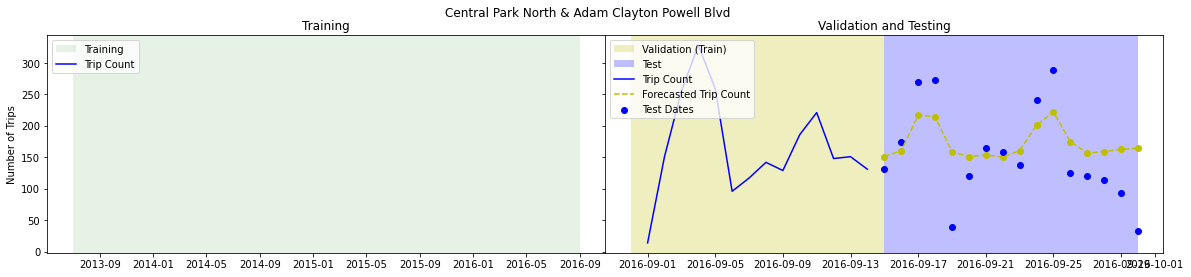

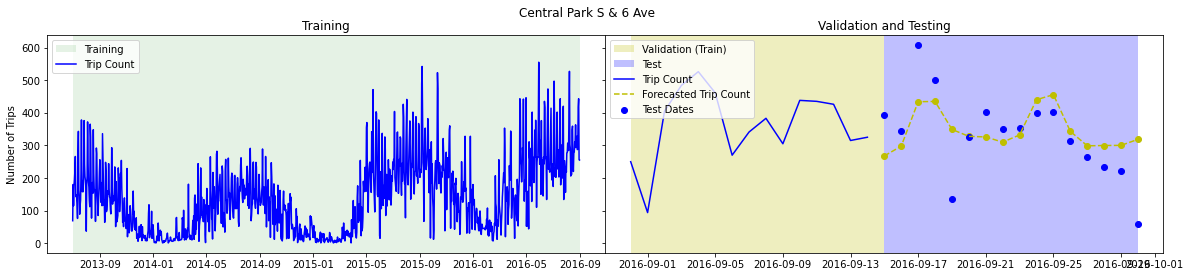

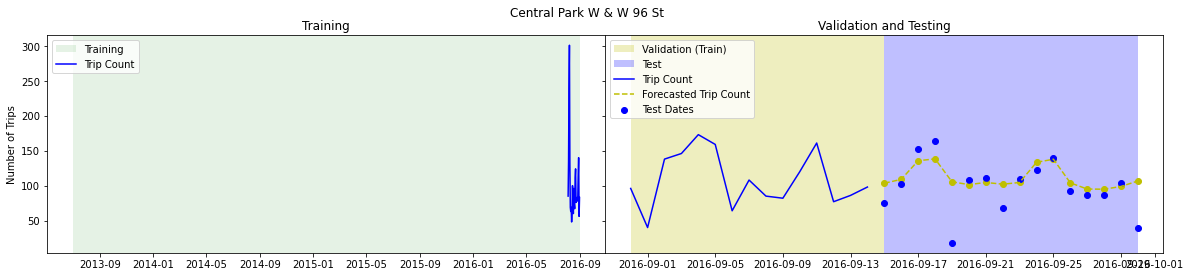

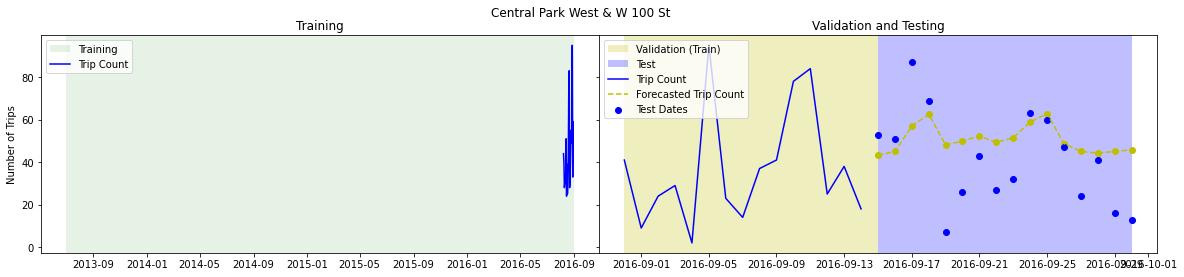

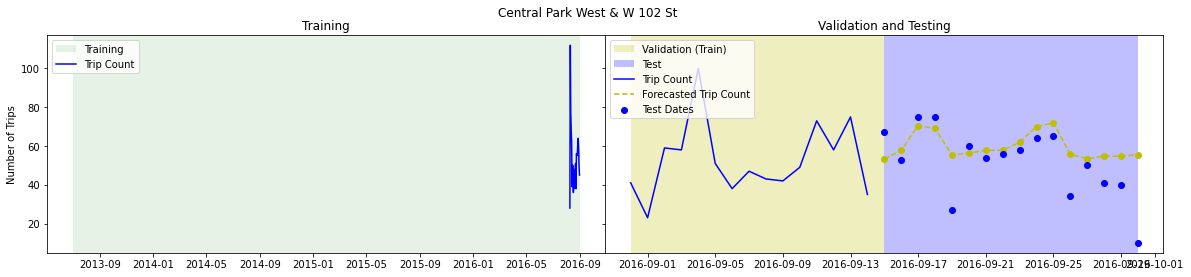

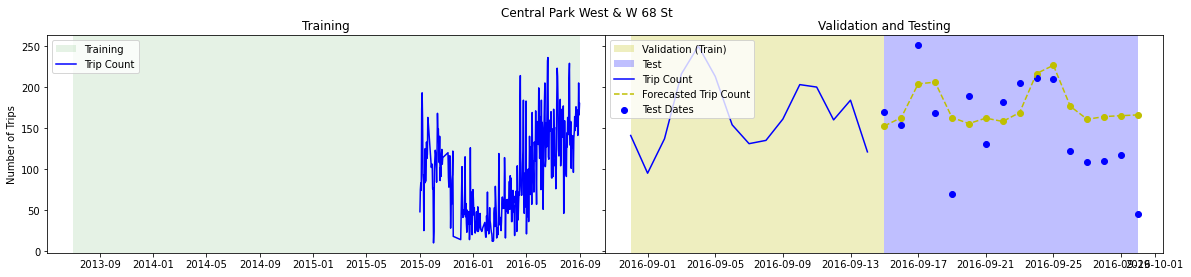

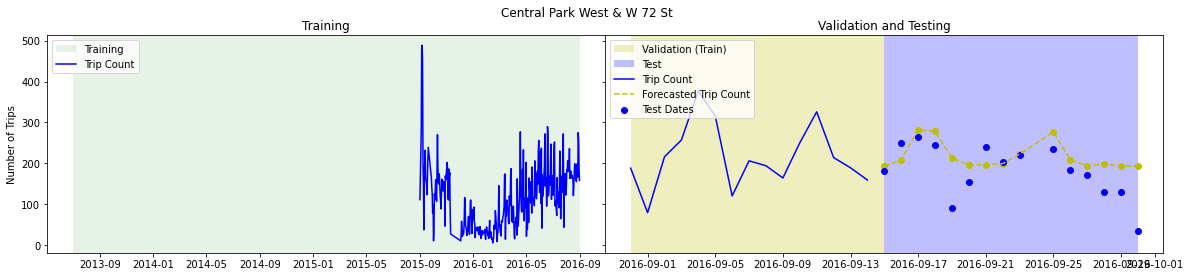

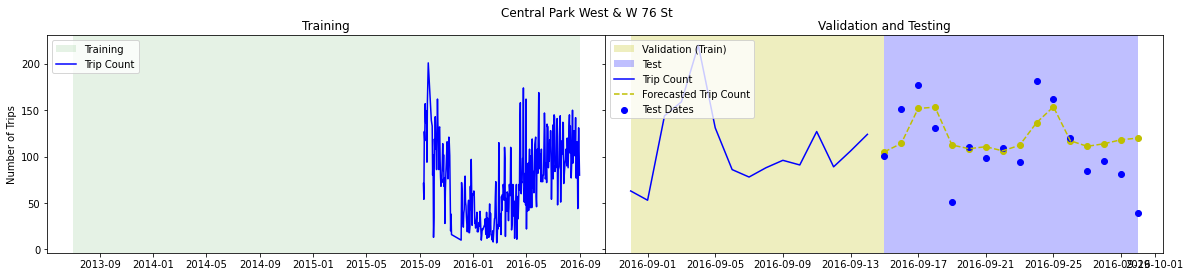

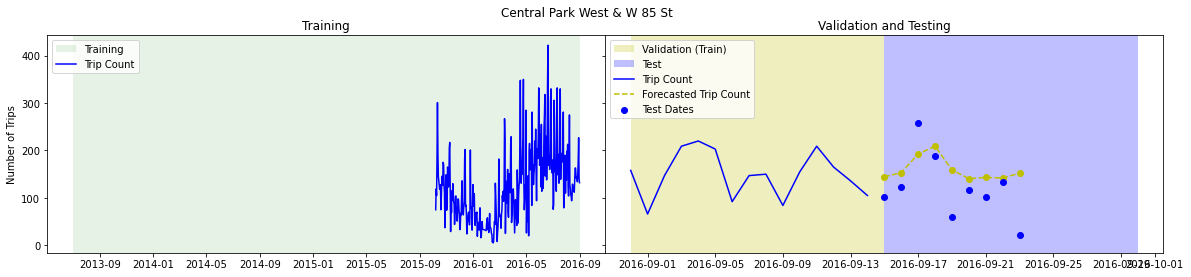

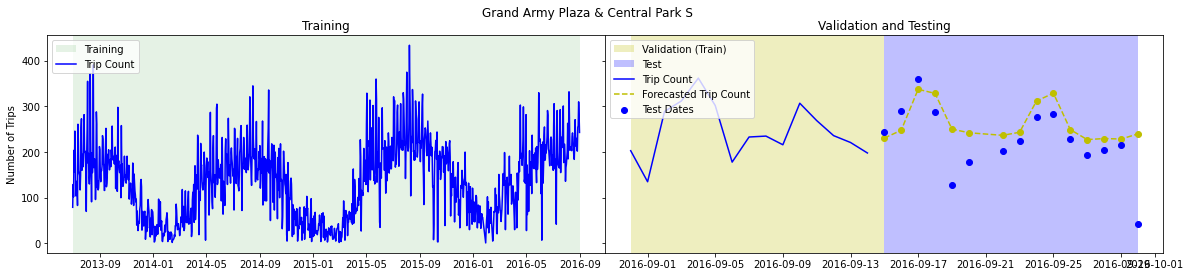

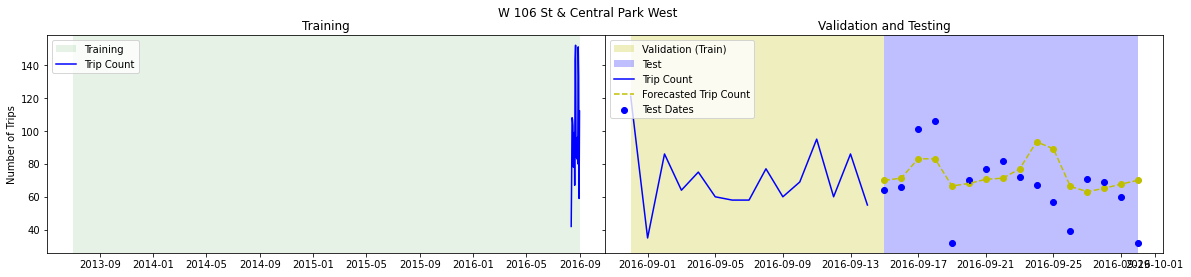

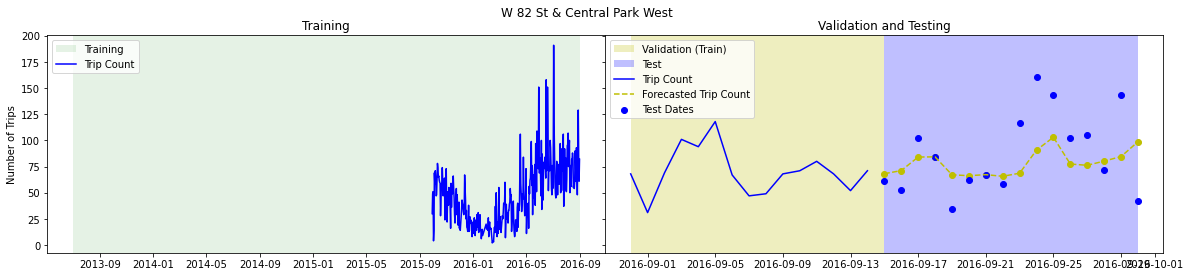

In [11]:
stations = rawSeries['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TEST')]
    fit_testdf = autoML[(autoML['start_station_name'] == st) & (autoML['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    #axes[1].plot(testdf['date'], testdf['num_trips'], color = 'b')
    
    axes[1].plot(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    axes[1].scatter(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y')
    
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st)

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"